In [1]:
from google.colab import drive
drive.mount('/gdrive')

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report, roc_auc_score
import os
from PIL import Image
from tqdm import tqdm

Mounted at /gdrive


In [2]:
test_size = 0.05

In [3]:
# Function to load images and masks
def load_images_and_masks(image_dir, mask_dir, test_size):
    image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tif')])
    mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir) if file.endswith('.tif')])

    total_count = len(image_files)
    load_count = int(total_count * test_size)

    # Truncate the lists to the number of images to be loaded
    image_files = image_files[:load_count]
    mask_files = mask_files[:load_count]

    images = []
    masks = []

    print(f"Attempting to load {test_size * 100:.1f}% of {total_count}: {load_count} image/mask pairs")
    print("Loading Images and Masks...")
    print(f"Total Images: {len(image_files)}")
    print(f"Total Masks: {len(mask_files)}")

    for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
        image = Image.open(image_file)
        mask = Image.open(mask_file)

        images.append(np.array(image))
        masks.append(np.array(mask))

    # Ensure the number of images and masks are equal
    if len(images) != len(masks):
        raise ValueError("The number of images and masks must be equal.")

    return np.array(images), np.array(masks)

# Specify the paths to your image and mask directories
image_dir = '/gdrive/My Drive/Dataset/patches/test/images'
mask_dir = '/gdrive/My Drive/Dataset/patches/test/masks'

test_images, test_labels = load_images_and_masks(image_dir, mask_dir, test_size)
print(f'\nDataset Loaded...')
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Masks Shape: {test_labels.shape}")

Attempting to load 5.0% of 845: 42 image/mask pairs
Loading Images and Masks...
Total Images: 42
Total Masks: 42


100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


Dataset Loaded...
Test Images Shape: (42, 256, 256, 3)
Test Masks Shape: (42, 256, 256)


In [7]:
# Metric functions
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon())

def jaccard_index(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + epsilon()) / (union + epsilon())

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + epsilon())

# LOSS
def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce * (weights[1] * y_true + weights[0] * (1 - y_true))
        return tf.keras.backend.mean(weighted_bce)
    return loss

weighted_loss = weighted_binary_crossentropy([0.5339968946194886, 7.853612816644959])

In [9]:
model_path = '/gdrive/My Drive/Dataset/Models/unet_vgg_4.h5'
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient, 'jaccard_index': jaccard_index, 'sensitivity': sensitivity, 'specificity': specificity, 'precision': precision, 'loss': weighted_loss})
print('Model Loaded...')
model.summary()

Model Loaded...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                              

2/2 [==============================] - 76s 17s/step
Optimal Thresholds: {'dice': 0.9749999999999998, 'iou': 0.9749999999999998, 'precision': 0.1, 'recall': 0.9749999999999998, 'roc_auc': 0.1}


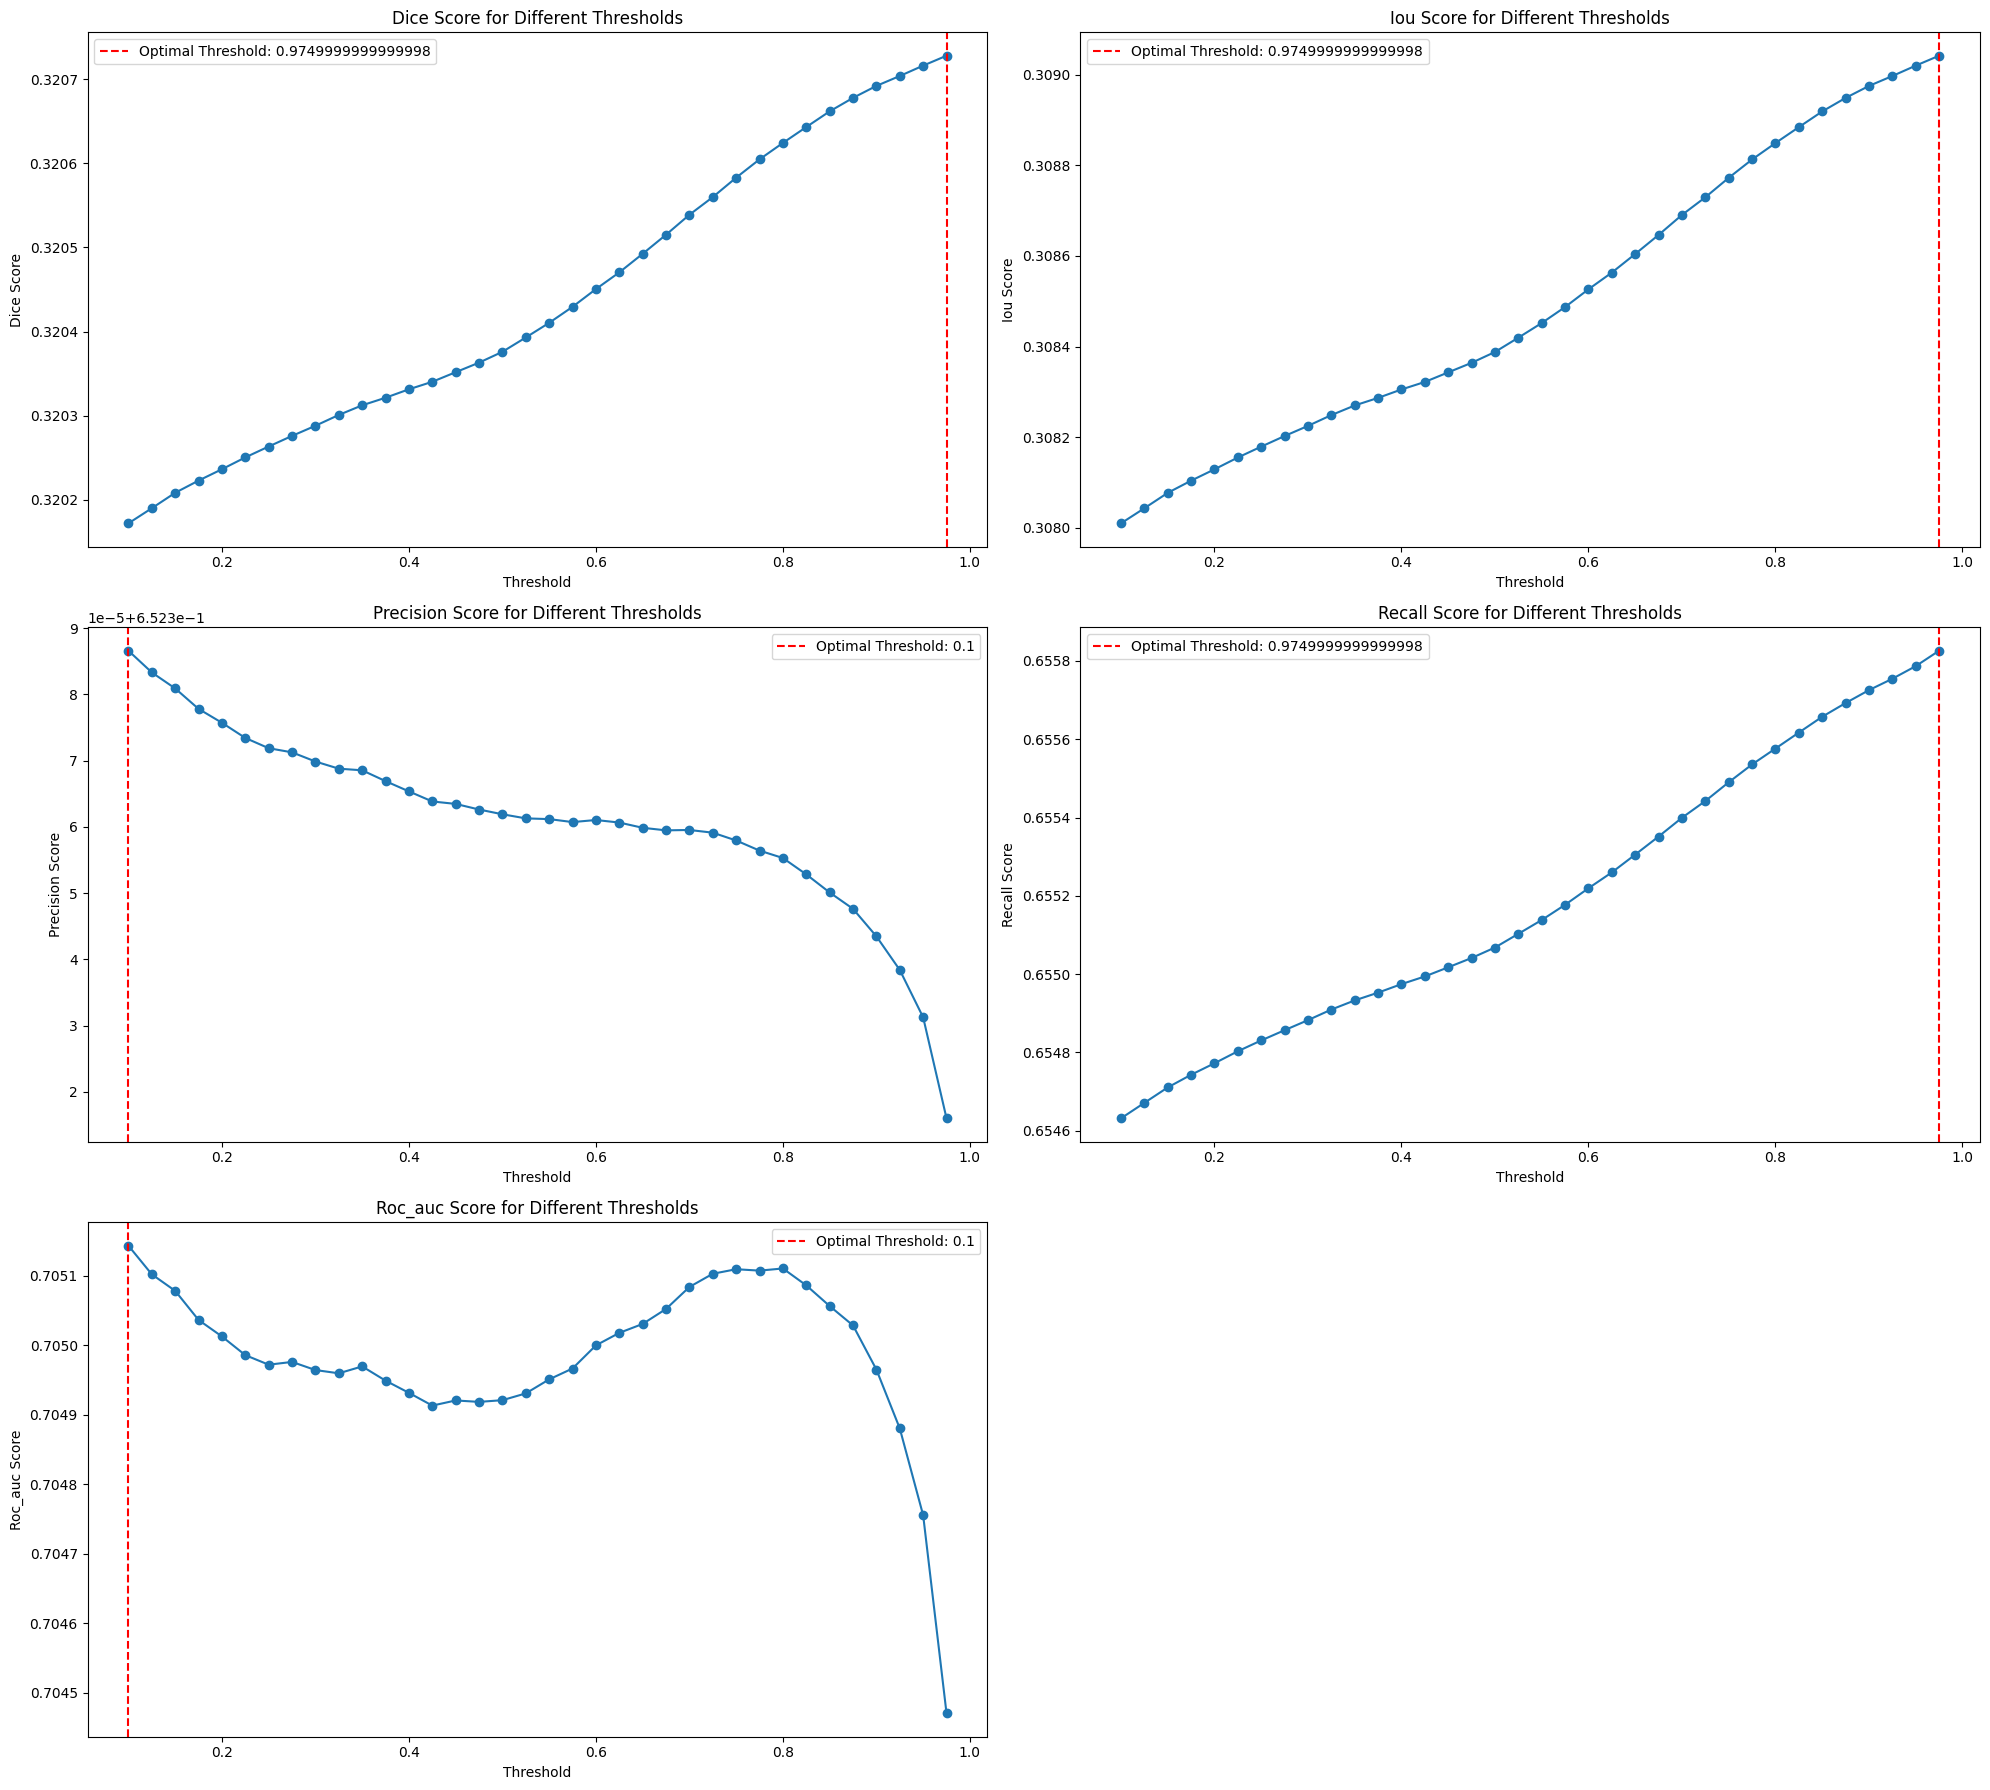

Optimal Thresholds by Metrics:
Dice: 0.9749999999999998
Iou: 0.9749999999999998
Precision: 0.1
Recall: 0.9749999999999998
Roc_auc: 0.1

IoU for the building class: 0.3114744217050306
IoU Score: 0.6192994222374362
Dice Score: 0.7185915707729785
Precision: 0.7354988860716274
Recall: 0.7044702077761562
ROC-AUC Score: 0.7321053455679181


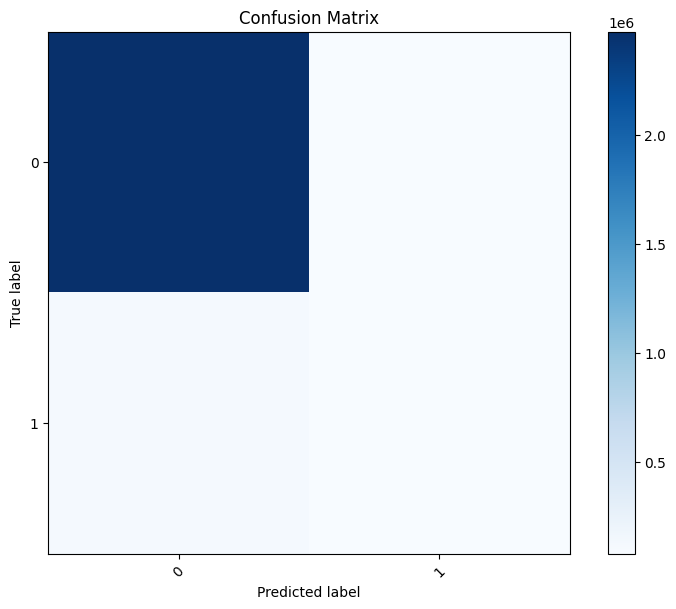

              precision    recall  f1-score   support

           0       0.96      0.97      0.96   2553521
           1       0.51      0.44      0.47    198991

    accuracy                           0.93   2752512
   macro avg       0.74      0.70      0.72   2752512
weighted avg       0.92      0.93      0.93   2752512



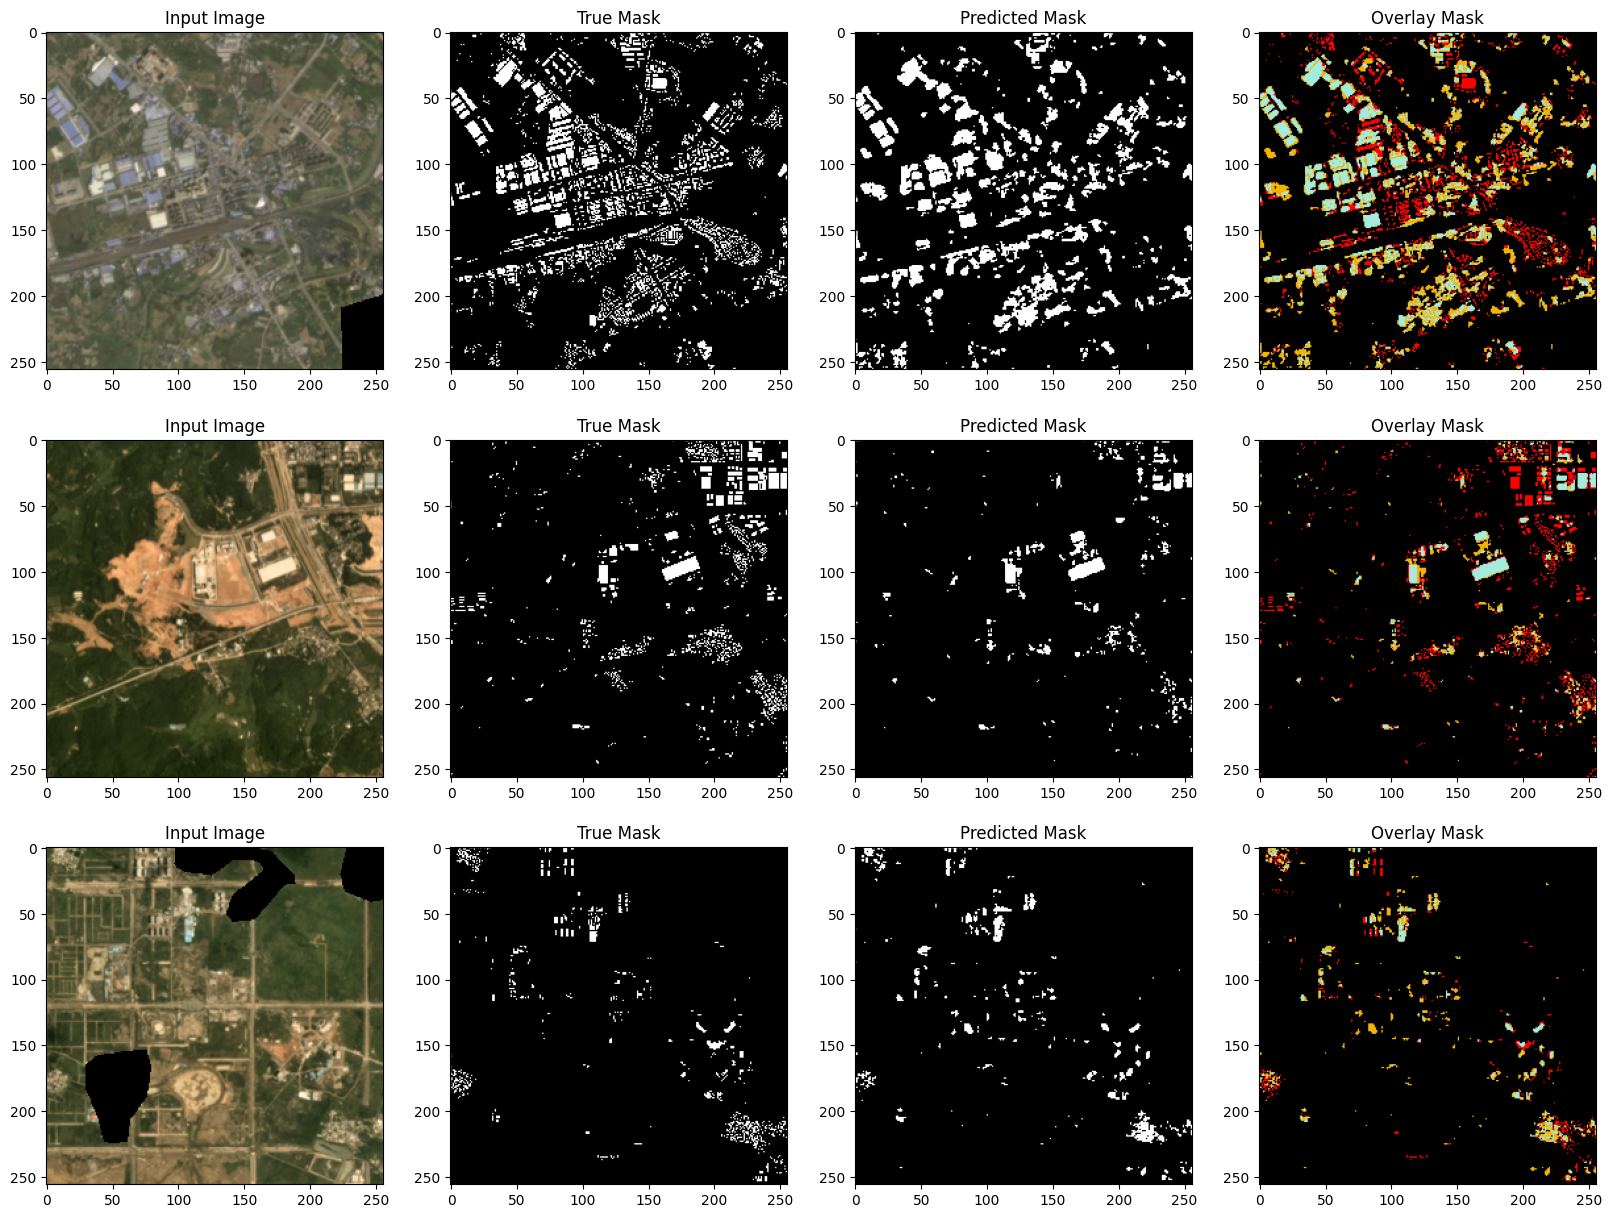

In [10]:
# Make predictions
predictions = model.predict(test_images)

# Check the shape of the predictions, and if the last dimension is 1, squeeze it out
if predictions.ndim == 4 and predictions.shape[-1] == 1:
    predictions = np.squeeze(predictions, axis=-1)

# Function to find the optimal threshold and store scores for each metric and threshold
def find_optimal_threshold(y_true, y_pred_probs, thresholds=np.arange(0.1, 1, 0.0125)):
    best_thresholds = {
        'dice': 0.5,
        'iou': 0.5,
        'precision': 0.5,
        'recall': 0.5,
        'roc_auc': 0.5
    }
    best_scores = {
        'dice': 0.0,
        'iou': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'roc_auc': 0.0
    }
    score_lists = {
        'dice': [],
        'iou': [],
        'precision': [],
        'recall': [],
        'roc_auc': []
    }

    for threshold in thresholds:
        y_pred = (y_pred_probs > threshold).astype(int)
        dice = f1_score(y_true.flatten(), y_pred.flatten(), average='macro')
        iou = jaccard_score(y_true.flatten(), y_pred.flatten(), average='macro')
        precision = precision_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=1)
        recall = recall_score(y_true.flatten(), y_pred.flatten(), average='macro', zero_division=1)
        roc_auc = roc_auc_score(y_true.flatten(), y_pred.flatten())

        score_lists['dice'].append(dice)
        score_lists['iou'].append(iou)
        score_lists['precision'].append(precision)
        score_lists['recall'].append(recall)
        score_lists['roc_auc'].append(roc_auc)

        if dice > best_scores['dice']:
            best_scores['dice'] = dice
            best_thresholds['dice'] = threshold
        if iou > best_scores['iou']:
            best_scores['iou'] = iou
            best_thresholds['iou'] = threshold
        if precision > best_scores['precision']:
            best_scores['precision'] = precision
            best_thresholds['precision'] = threshold
        if recall > best_scores['recall']:
            best_scores['recall'] = recall
            best_thresholds['recall'] = threshold
        if roc_auc > best_scores['roc_auc']:
            best_scores['roc_auc'] = roc_auc
            best_thresholds['roc_auc'] = threshold

    return best_thresholds, best_scores, score_lists

# Determine the optimal threshold
thresholds = np.arange(0.1, 1, 0.025)
optimal_thresholds, best_scores, score_lists = find_optimal_threshold(test_labels, predictions, thresholds)

print(f"Optimal Thresholds: {optimal_thresholds}")

# Plot the scores for each metric in a grid fashion
metrics = ['dice', 'iou', 'precision', 'recall', 'roc_auc']
fig, axs = plt.subplots(3, 2, figsize=(20, 18))  # 3 rows, 2 columns

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    axs[row, col].plot(thresholds, score_lists[metric], marker='o')
    axs[row, col].set_xlabel('Threshold')
    axs[row, col].set_ylabel(f'{metric.capitalize()} Score')
    axs[row, col].set_title(f'{metric.capitalize()} Score for Different Thresholds')
    axs[row, col].axvline(optimal_thresholds[metric], color='r', linestyle='--', label=f'Optimal Threshold: {optimal_thresholds[metric]}')
    axs[row, col].legend()

# Hide the last subplot if there is an odd number of metrics
if len(metrics) % 2 != 0:
    fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

# Iterate over each metric and display the optimal threshold for each
print('Optimal Thresholds by Metrics:')
for metric in metrics:
    print(f"{metric.capitalize()}: {optimal_thresholds[metric]}")
print()

# Apply the optimal threshold to binarize the predictions
predictions_binary = (predictions > optimal_thresholds['dice']).astype(int)

# Ensure test_labels has the same shape as predictions
if test_labels.ndim == 4 and test_labels.shape[-1] == 1:
    test_labels = np.squeeze(test_labels, axis=-1)

# Ensure that test_labels is a binary mask as well
test_labels = (test_labels > 0.5).astype(int)

# Function to calculate IoU for the building class
def calculate_iou(true_masks, pred_masks, pos_label=1):
    intersection = np.logical_and(true_masks == pos_label, pred_masks == pos_label).sum()
    union = np.logical_or(true_masks == pos_label, pred_masks == pos_label).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# Calculate metrics
iou_building_class = calculate_iou(test_labels, predictions_binary)
iou_score = jaccard_score(test_labels.flatten(), predictions_binary.flatten(), average='macro')
dice_score = f1_score(test_labels.flatten(), predictions_binary.flatten(), average='macro')
prec_score = precision_score(test_labels.flatten(), predictions_binary.flatten(), average='macro', zero_division=1)
recall_score = recall_score(test_labels.flatten(), predictions_binary.flatten(), average='macro', zero_division=1)
roc_auc = roc_auc_score(test_labels.flatten(), predictions.flatten())

# Print metrics
print(f"IoU for the building class: {iou_building_class}")
print(f"IoU Score: {iou_score}")
print(f"Dice Score: {dice_score}")
print(f"Precision: {prec_score}")
print(f"Recall: {recall_score}")
print(f"ROC-AUC Score: {roc_auc}")

# Create and plot a standard confusion matrix
conf_matrix = confusion_matrix(test_labels.flatten(), predictions_binary.flatten())
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1], rotation=45)
plt.yticks(tick_marks, [0, 1])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report
print(classification_report(test_labels.flatten(), predictions_binary.flatten(), zero_division=1))

# Randomly select some examples to plot
indices = np.random.choice(range(len(test_images)), 3, replace=False)
sample_images = test_images[indices]
sample_true_masks = test_labels[indices]
sample_pred_masks = predictions_binary[indices]

def plot_examples_with_overlay(images, true_masks, pred_masks, num_examples=3):
    fig, axs = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
    for i in range(num_examples):
        axs[i, 0].imshow(images[i])
        axs[i, 0].title.set_text('Input Image')

        axs[i, 1].imshow(true_masks[i], cmap='gray')
        axs[i, 1].title.set_text('True Mask')

        axs[i, 2].imshow(pred_masks[i], cmap='gray')
        axs[i, 2].title.set_text('Predicted Mask')

        # Create an overlay image
        overlay = np.zeros((*true_masks[i].shape, 3), dtype=np.uint8)
        # True Positives to Blue
        overlay[(true_masks[i] == 1) & (pred_masks[i] == 1)] = [164, 236, 222]
        # False Positives to Red
        overlay[(true_masks[i] == 0) & (pred_masks[i] == 1)] = [243, 179, 0]
        # False Negatives to Orange
        overlay[(true_masks[i] == 1) & (pred_masks[i] == 0)] = [255, 0, 0]

        axs[i, 3].imshow(overlay)
        axs[i, 3].title.set_text('Overlay Mask')

    plt.show()

plot_examples_with_overlay(sample_images, sample_true_masks, sample_pred_masks)


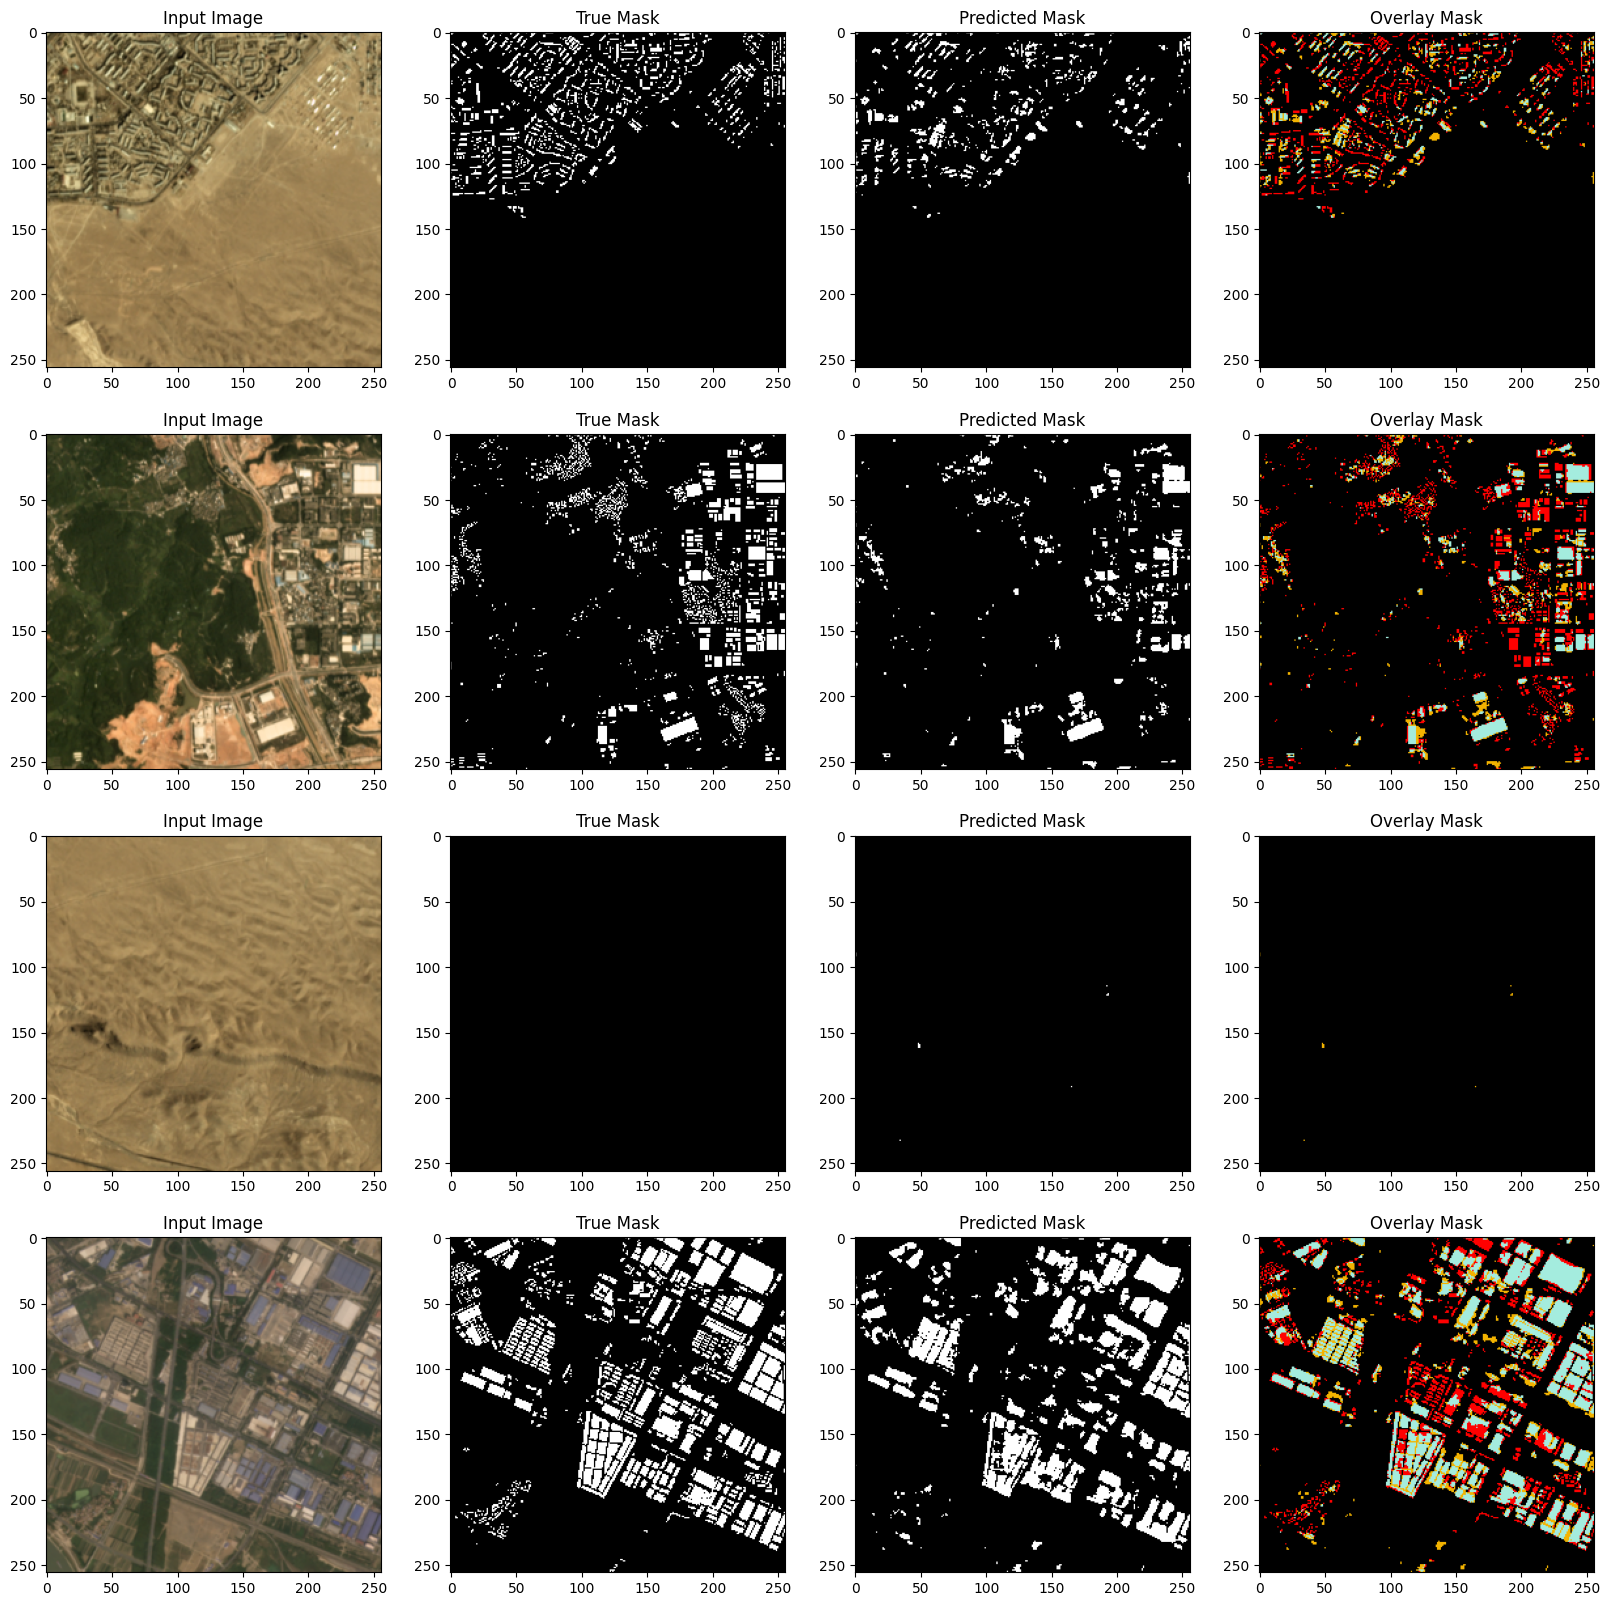

In [11]:
# Randomly select some examples to plot
indices = np.random.choice(range(len(test_images)), 5, replace=False)
sample_images = test_images[indices]
sample_true_masks = test_labels[indices]
sample_pred_masks = predictions_binary[indices]

def plot_examples_with_overlay(images, true_masks, pred_masks, num_examples=4):
    fig, axs = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))  # Increase the number of columns to 4
    for i in range(num_examples):
        axs[i, 0].imshow(images[i])
        axs[i, 0].title.set_text('Input Image')

        axs[i, 1].imshow(true_masks[i], cmap='gray')
        axs[i, 1].title.set_text('True Mask')

        axs[i, 2].imshow(pred_masks[i], cmap='gray')
        axs[i, 2].title.set_text('Predicted Mask')

        # Create an overlay image
        overlay = np.zeros((*true_masks[i].shape, 3), dtype=np.uint8)
        # True Positives to Blue
        overlay[(true_masks[i] == 1) & (pred_masks[i] == 1)] = [164, 236, 222]
        # False Positives to Red
        overlay[(true_masks[i] == 0) & (pred_masks[i] == 1)] = [243, 179, 0]
        # False Negatives to Orange
        overlay[(true_masks[i] == 1) & (pred_masks[i] == 0)] = [255, 0, 0]

        axs[i, 3].imshow(overlay)
        axs[i, 3].title.set_text('Overlay Mask')

    plt.show()

plot_examples_with_overlay(sample_images, sample_true_masks, sample_pred_masks)